**CFP example 1 (Shoemaker et al. 2007)**

 *Input files needed:*
    <br>mf2005cfp.exe
    <br>network_info.csv and .txt
    <br>geoheight.txt
    <br>pipe_info.txt
    <br>node_head.txt
    <br>K_exch.txt


*MODFLOW input files generated:*
   <br>DIS - Discretization input
   <br>BAS6 - Basic
   <br>LPF - Layer-Property Flow
   <br>OC  - Output Control
   <br>COC - CFP Output Control
   <br>PCG - Preconditioned Conjugate Gradient
   <br>RCH - Recharge
   <br>CRCH - CFP Recharge
   <br>CFP - CFP conduit flow process
   
*MODFLOW output generated:*
   <br>LIST - list file
   <br>CBB - cell budget file
   <br>HDS - head file
    
*Model description:*
<br>See Shoemaker et al. 2007 for complete description. 4 rows, 4 columns, 3 layers, 5 stress periods. Cells are 10m x 10m x 1m. Leftmost column is a constant head boundary of 20m. (Right boundary also constant head? 20.3m?). Matrix Khorizontal = 1000 m/d, Kvertical = 200 m/d. Specific yield = 0.2, Storage coefficient = 0.00002. Five conduit nodes and four conduit pipes. 
Mean pipe water temperature = 25°C. The elevations of the pipes = 4.5 m above the datum, and SA_EXCHANGE = 1 so the CFP would use the surface area of pipes in cells to compute the pipe conductance. Solution controls for the pipe flow equations included a value of 0.000001 for convergence criterion (EPSILON), 100 maximum iterations (NITER), and the relaxation parameter (RELAX) = 1.0. Each pipe diameter, tortuosity, and roughness heights were set to constant values of 0.1, 1.0, and 0.01 m, respectively. The critical Reynolds numbers (NRe) for each pipe were assigned constant values equal to 10.0 for LCRITREY_P and 20.0 for TCRITREY_P. These values may be lower than generally expected for straight, nontortuous, and rough pipes; nevertheless, they were chosen so that both laminar and turbulent pipe flow equations could be demonstrated using this example problem. A constant node head equal to 20.0 m above the datum was assigned for node 2, and a solution was desired for the remaining node heads. Conduit wall permeabilities = 5.0 m/d. The transient model boundary is net recharge. Values of 0.003, 0.001, 0.002, 0.003, 0.002 m/d were assigned for net recharge to the uppermost active model layer for stress periods 1 through 5, respectively, using the RCH Package. The CRCH Package was employed, which routed all of the net recharge assigned to MODFLOW cell 3,3,1 (j,i,k) into conduit node 4.

**Setup**

In [1]:
# Imports:

#Python packages:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import os
import sys
import shutil
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Local modules:
import mfcfp

In [2]:
# Directories:

#Define paths for different folders:
main_path = r'C:\Users\Chloe\Documents\PYTHON\GOTTESACKER\CFP\testing'
MODFLOWfiles_path = r'C:\Users\Chloe\Documents\PYTHON\GOTTESACKER\CFP\testing\MODFLOW IO files'
fig_path = r'C:\Users\Chloe\Documents\PYTHON\GOTTESACKER\CFP\testing\figures'

#Check if folders already exist, and if not, create them & copy in the mf executable:
if not os.path.exists(MODFLOWfiles_path):
    os.makedirs(MODFLOWfiles_path)
    shutil.copy2(main_path+'\mf2005cfp.exe',MODFLOWfiles_path)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

**Create FloPy objects for MODFLOW input files**
<br>
<br>*Standard MODFLOW files to create:*  DIS, BAS6, LPF, PCG, OC, RCH
<br>*MODFLOW-CFP files to create:*       CRCH, CFP, COC

In [3]:
# Create model object:
# Note: MODFLOW executable must be in same folder

modelname = "CFP_ex1"                                        #model name
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005cfp')  #create model object and specify modflow version


Standard files:

In [4]:
# DIS (Discretization): Creates model grid
# documentation: https://modflowpy.github.io/flopydoc/mfdis.html

# Model grid:
# Note: MODFLOW defaults to units of m/day
nrow = 4           #number of rows (integer)
ncol = 4           #number of columns (integer)
nlay = 3           #number of layers (integer)
delr = 10.0        #width of each cell along rows (so really this is column width along x axis) (float, i.e. decimal)
delc = 10.0        #width of each cell along columns (so really this is row height along y axis) (float)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height
ztop = 5.0         #top elevation (float)
zbot = 2.0         #bottom elevation (float)
#delr = Lx/ncol    #cell width along the rows - if defining total model width uncomment this and comment out lines 47 & 48
#delc = Ly/nrow    #cell width along the columns
delv = (ztop - zbot) / nlay     #cell height in z axis
botm = np.linspace(ztop-delv, zbot, nlay) #bottom elevation of each layer - linspace generates an array of nlay+1 linearly spaced values between ztop and zbot

# Time periods:
nper = 5                #number of stress periods
perlen = 100.0          #stress period duration (float array)
nstp = [1,10,10,10,10]  #number of time steps in each stress period (integer array)
steady = [True, False, False, False, False] #is stress period steady-state or transient? (boolean true/false array) 
spers = np.arange(1,nper+1) #array of stress period numbers

# Create dis object:
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper, delr, delc, top=ztop, botm=botm,
                              perlen=perlen, nstp=nstp, steady=steady) 


In [5]:
# BAS6 (Basic): Assigns constant head boundaries.
# if ibound < 0, constant head, if = 0, inactive, if > 0 active.
# create arrays to indicate active cells (ibound) and starting heads (H_init)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)    #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column with -1 to indicate constant head 
ibound[:,:,ncol-1] = -1     #replace rightmost column with -1 to indicate constant head 

H_left = 20.                #constant head value at left boundary
H_right = 20.3              #constant head value at right boundary
H_rows = np.linspace(H_left, H_right, ncol) #creates linearly spaced head values to use along rows
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:,:,:] = H_rows      #assign starting head values to all cells

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=H_init)    #create BAS object


In [6]:
# LPF (Layer Property Flow): Assigns horizontal & vertical flow parameters between cells
# Only one of either the BCF, LPF, or HUF2 packages should be used to control flow between cells
# Can also in this package set confined/unconfined (defaults to confined), cell-by-cell Ks as an array, 
# storage, specific yield, etc.
# defaults to confined

ipakcb = 50    #unit number to save outputs to
hdry = 999.    #value assigned to dry cells
laytyp = 1     #0=confined, >0 = unconfined/convertible
layavg = 0     #method of calculating interblock tranmissivity, 0=harmonic mean (default)
chani = 1      #horizontal anisotropy (ratio of Ky (along cols) to Kx (along rows)
layvka = 0     #indicates vka = Kz
laywet = 0     #wetting, 0=inactive, 1=active

hk = 1000.     #horizontal hydraulic cond along rows
vka = 200.     #vertical hydraulic conductivity 
ss = 0.00002   #specific storage 
sy = 0.2       #specific yield

lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=chani, layvka=layvka, laywet=0, 
            ipakcb=ipakcb, hdry=hdry, hk=hk, hani=chani, vka=vka, ss=ss, sy=sy, wetdry=laywet) 


In [7]:
# OC (Output Control): Decides what outputs to save
# This rarely needs to be changed

spd = {(0,0):['print head', 'save head', 'save budget'],
      (1,0):['print head', 'save head', 'save budget'],
      (2,0):['print head', 'save head', 'save budget'],
      (3,0):['print head', 'save head', 'save budget'],
      (4,0):['print head', 'save head', 'save budget']} #dictionary for stress period data, where key (0,0) is a tuple with the zero-based period and step for each print/save 

oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)   #create output control file using dictionary


In [8]:
# PCG (Preconditioned Conjugate Gradient):
# This rarely needs to be changed

mxiter = 20      #max number of outer iterations
iter1 = 10       #number of inner iterations
npcond = 1       #flag for matrix conditioning method, 1=modified incomplete cholesky 
ihcofadd = 9999  #flag for active cell surrounded by dry cells. 0=converts to dry, not0=converts only if hcof=0
hclose = 1e-5    #head change criterion for convergence
rclose = 1e-5    #residual criterion for convergence
relax = 0.97     #relaxation parameter with npcond=1
nbpol = 2        #estimate of upper bound
iprpcg = 5       #printout interval
mutpcg = 0       #print flag, 5=?
damppcg = 1.     #damping factor

pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, iter1=iter1, npcond=1, hclose=hclose, rclose=rclose, 
                relax=relax, nbpol=nbpol, iprpcg=iprpcg, mutpcg=mutpcg, damp=damppcg, ihcofadd=ihcofadd) 


In [9]:
# RCH: Recharge
# recharge flux distributed over the top of the model - MODFLOW multiplies the fluxes by the horizontal area of the cells 
# to which they are applied to calculate the volumetric flux rates

nrchop = 1   #flag, 1=rech only applied to top layer
#irchcb = 52  #unit number to save to
ipakcb = 50  #unit number to save to?

inrech = 1   #read recharge fluxes from rech
rech = {}    #dictionary of recharge fluxes for each stress period
rech[0] = 0.003 
rech[1] = 0.001 
rech[2] = 0.002
rech[3] = 0.003 
rech[4] = 0.002

rch = flopy.modflow.mfrch.ModflowRch(mf, nrchop=nrchop, ipakcb=ipakcb, rech=rech, irch=inrech)

CFP files:

In [10]:
# COC: CFP Output Control
# Controls the nodes for which to print flow and head values, and the pipes for which to print flow rates and 
# Reynolds numbers. 
# Documentation: https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?dis.htm
# Note: no FloPy support for this file

#Parameters:
nnodes = 5                           #ds2: NNODES: integer for number of nodes to generate head & flow output for (output will be in separate files)
node_nums = [1,2,3,4,5]              #ds4: NODE_NUMBERS: integers for node numbers to generate output for. One node per line. 1-based indexing
n_nts = 1                            #ds6: N_NTS: integer for time step interval to generate output for
npipes = 4                           #ds8: NPIPES: integer for number of pipes to generate flow & Reynolds number output for (output will be in separate files)
pipe_nums = [1,2,3,4]                #ds10: PIPE_NUMBERS: integers for pipe numbers to generate output for. One node per line. 1-based indexing
t_nts = 1                            #ds12: T_NTS: integer for time step interval to generate output for
coc_unit_num = 16                    #unit number for name file

coc = mfcfp.ModflowCoc(nnodes,node_nums,n_nts,npipes,pipe_nums,t_nts)

In [11]:
# CRCH: CFP Recharge
# Routes a fraction of diffuse recharge to conduit pipe nodes
# Documentation: https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?dis.htm
# Note: No FloPy support available
# Repeat entire dataset for each stress period

#All stress periods:
crch_unit_num = 18                    #unit number for name file
iflag_crch = [1,-1,-1,-1,-1]          #ds1: IFLAG_CRCH: integer flag to activate CRCH. Repeat for each stress period
                                      #if not -1, node_nums & p_crch are read for each node in simulation
                                      #if -1, node_nums & p_crch from last stress period are used
#Stress period 1:
node_nums = [1,2,3,4,5]               #ds2: NODE_NUMBERS: (only if iflag_crch not -1)
                                      #integer for node number, 1-based indexing, must include all nodes
p_crch = [0.00,0.00,0.00,1.00,0.00]   #ds2: P_CRCH: fraction of diffuse areal recharge (from RCH package) 
                                      #to partition directly into conduit node. List 0 if none.

crch = mfcfp.ModflowCrch(node_nums,spers,iflag_crch,p_crch)


In [12]:
# CFP: Primary conduit flow input - location, geometry, and properties of conduits
# Documentation: https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?dis.htm
# Note: FloPy is not supported
# Note: currently requires text files for arrays

#Inputs:
cfp_unit_num = 17      #unit number for name file
mode = 1               #ds1: MODE: flag, 1 = pipes only are active
nnodes = 5             #ds4: NNODES: total number of nodes in network
npipes = 4             #ds4: NPIPES: total number of pipes in network
#nlayers = nlay        #ds4: NLAYERS: number of layers in model (already defined earlier)
temp = 25.             #ds6: TEMPERATURE: avg groundwater temp in conduits
sa_exch = 1            #ds14: SA_EXCHANGE: integer flag, 1=assign conduit wall permeability & let cfp comput pipe surface area
epsilon = 10e-6        #ds16: EPSILON: convergence criterion (use a very small number)
niter = 100            #ds18: NITER: max number of iterations allowed
relax = 1              #ds20: RELAX: step length for iterations (<1 may improve convergence)
p_nr = 1               #ds22: P_NR: print flag, if 1, print iteration results

#Import network info as an array for plotting later
network_info = np.genfromtxt('network_info.csv', delimiter=',')  #ds8: NO_N, MC,MR,ML, NB1,NB2,NB3,NB4,NB5,NB6,PB1,PB2,PB3,PB4,PB5,PB6, node number, modflow col,row,lay, neighbor nodes (0 if none), connected pipes (0 if none)

cfp = mfcfp.ModflowCfp(nnodes,npipes,nlay,
                'network_info.txt','geoheight.txt','pipe_info.txt','node_head.txt','K_exch.txt',
                mode,temp,sa_exch,epsilon,niter,relax,p_nr)


**Write input files & run MODFLOW**

In [13]:
# Write MODFLOW input files & update name file:

os.chdir(MODFLOWfiles_path) #changes current folder to inputs folder
mf.write_input()     #uses the package objects created above to actually write the text files 
                     #(for standard MODFLOW only), and saves to current folder
    
filenames = ['coc', 'crch', 'cfp']     #list which cfp files to write
dataset_strings = [coc, crch, cfp]     #list dataset strings for each cfp file
mfcfp.cfp_write_input(modelname, dataset_strings, filenames)   #call write function from mfcfp module
mfcfp.update_nam(modelname, coc_unit_num, crch_unit_num, cfp_unit_num)


In [14]:
# Run MODFLOW:

success, buff = mf.run_model()     #run MODFLOW


FloPy is using the following executable to run the model: mf2005cfp.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.8.00_cfp 02/23/2011                   

 Using NAME file: CFP_ex1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/08/13  9:50:08

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow 

**Post-processing**

In [15]:
# Get model outputs:

obs_loc = (0,2,2)                       #choose location to measure heads (lay,row,col), zero-based indexing

lst = flopy.utils.MfListBudget(modelname+'.list')   #read the list file
hds = bf.HeadFile(modelname+'.hds')                 #read the binary head file 
h_times = hds.get_times()                           #return a list of head print times
b_times = lst.get_times()                           #return a list of budget print times

heads = []                                  #initialize empty list
for t in h_times:                           #loop over stress periods
    heads.append(hds.get_data(totim=t))     #append heads for specified print time
heads = np.asarray(heads)                   #convert to numpy array

budgets = []
for t in b_times:
    budgets.append(lst.get_data(totim=t, incremental=True))

obs_ts = hds.get_ts(obs_loc)                #get a time series of heads at a specific location

In [16]:
# Get CFP output at a specific node:

node_num = 2               #node to get observations for
[t,Q_n2] = mfcfp.node_budget(modelname,node_num,'.list')   #get flow rates at specified node


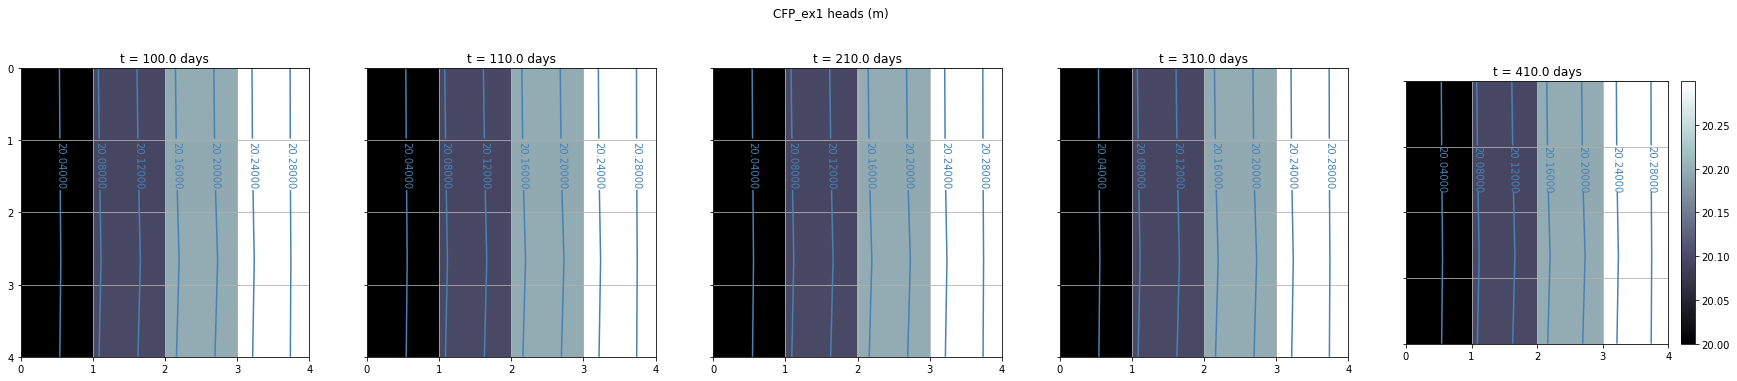

In [17]:
# Plot head contours in selected layer at each timestep:

lay = 0                         #choose layer to plot (zero-based indexing)
data = heads                    #choose data to plot
title = modelname+' heads (m)'   #choose plot title

# Create standard plotting grid and maximum and minimum values, so that different datasets can be compared
mn = np.amin(data)              #get minimum head
mx = np.amax(data)              #get maximum head
levels = np.arange(mn,mx,10)    #create a linearly spaced array of values from min to max, used to determine which contour values to draw
extent = (0, ncol, 0, nrow)     #sets plot boundaries (x0,x1,y0,y1)
ticks = np.arange(0,nrow+1)     #creates an array for major tick marks

def plot_map(data,mx,mn,levels,extent,ticks,title):

    fig,ax = plt.subplots(ncols=nper, sharex=True, sharey=True, figsize=(nper*6,6))  #create & return empty figure & axes for each print time 

    for t in np.arange(nper):          #loop over print times
        ax[t].set_aspect('equal')     #set a square aspect ratio
        c = ax[t].contour(data[t,lay,:,:], extent=extent, colors='SteelBlue')  #plots contours for all rows & columns in layer 1
        im = ax[t].imshow(data[t,lay,:,:],cmap='bone', extent=extent, vmin=mn,vmax=mx) #plot colormap of data
        ax[t].set_title('t = ' + str(h_times[t]) + ' days')        #adds subplot title
        ax[t].invert_yaxis()
        ax[t].clabel(c, fmt='%1.5f')                             #adds contour labels as floats with 2 decimal places 
        ax[t].yaxis.set_major_formatter(FormatStrFormatter('%d')) #formats axis labels as integers
        ax[t].xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax[t].set_xticks(ticks)            
        ax[t].set_yticks(ticks)
        ax[t].grid(which='major')          #turns grid on 

    plt.suptitle(title)        #adds a title
    divider = make_axes_locatable(ax[t])   #set up colorbar location - find main axes location at last time
    cax = divider.append_axes("right", size='5%', pad='5%')  #place colorbar axes on right side of each subplot
    plt.colorbar(mappable=im, cax=cax, ax=ax)               #draw colorbar
    plt.show()                              #actually displays figures below (not all computers need this)
    
f1 = plot_map(data,mx,mn,levels,extent,ticks,title)

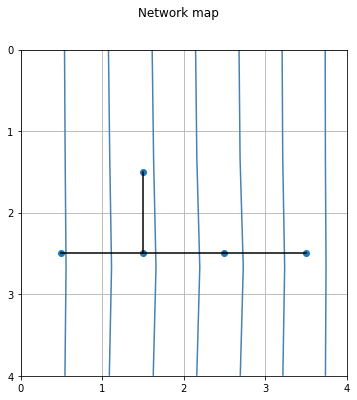

In [18]:
# Plot pipe network

#Format data for plotting:
node_cells = network_info[:,1:3]   #get node col,row
node_xy = node_cells-0.5           #set to center of cell
pipe_connections = [[1,3],[2,3],[3,1],[3,2],[3,4],[4,3],[4,5],[5,4]]  #list of all connected pipe numbers
pipe_connections = set(map(frozenset, pipe_connections))   #converts to a frozen set, then removes duplicates (even if reversed)
pipe_connections = list(map(list, pipe_connections))       #converts back to list

#Define pipe-plotting function:
def plot_pipes(node_xy,pipe_connections,color):
    #node_xy is a list of [x,y] coordinates for node locations
    #pipe_connections is a list of all node pairs that are connected by a pipe
    #color is a standard python color string
    for i in range(len(pipe_connections)):
        n1 = pipe_connections[i][0] - 1         #pull node 1 index
        n2 = pipe_connections[i][1] - 1         #pull node 2 index
        x = [node_xy[n1][0],node_xy[n2][0]]     #pull x1 and x2 coordinates
        y = [node_xy[n1][1],node_xy[n2][1]]     #pull y1 and y2 coordinates
        plt.plot(x,y,color)                     #plot a line connecting node 1 with node 2

#Plot:
fig,ax = plt.subplots(1,1,figsize=(6,6))  #create & return empty figure & axes 

ax.set_aspect('equal')                    #set a square aspect ratio
plt.scatter(node_xy[:,0],node_xy[:,1])    #plot node locations as dots
c = ax.contour(data[-1,0,:,:], extent=extent, colors='SteelBlue')  #plots contours for all rows & columns in layer 1 at last timestep
plot_pipes(node_xy,pipe_connections,'k')
ax.invert_yaxis()
ax.yaxis.set_major_formatter(FormatStrFormatter('%d')) #formats axis labels as integers
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_xticks(ticks)            
ax.set_yticks(ticks)
ax.grid(which='major')          #turns grid on 

plt.suptitle('Network map')        #adds a title
plt.show()  

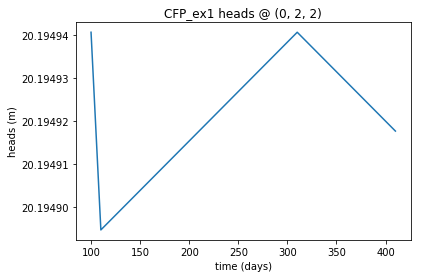

In [19]:
# Plot time series of heads at a specified observation location

x = obs_ts[:,0]
y = obs_ts[:,1]
title = 'heads @ ' + str(obs_loc)

f,ax = plt.subplots(1,1)
ax.plot(x, y)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.5f')) #formats axis labels as integers
plt.title(modelname + ' ' + title)
plt.xlabel('time (days)')
plt.ylabel('heads (m)')
plt.show()
    

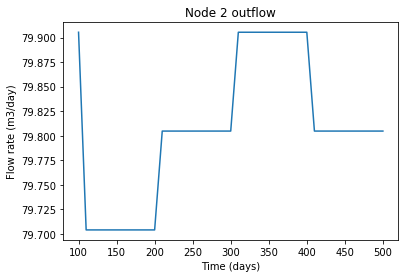

In [20]:
#Plot hydrograph at specified observation node:

title = 'Node 2 outflow'
Q_n2 = [Q_n2[i]*-1 for i in range(len(Q_n2))]       #convert negative outflows to positive numbers
plt.plot(t,Q_n2)                                  #plot node flow rate over time
plt.ylabel('Flow rate (m3/day)')           
plt.xlabel('Time (days)')
plt.title(title)

os.chdir(fig_path)
plt.savefig('modelname'+ '_' + title)

In [21]:
# Print budget 

for t in range(len(b_times)):         #loop over print times
    budget = budgets[t]                 #select budget for current time
    labels = [str(budget[i]['name'])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
    vals = [budget[i]['value'] for i in np.arange(len(budget))]   #get values for each budget item    
    print('\n','%25s'%'BUDGET (L**3/T):','\t','%10s'%'time = '+str(b_times[t]),'\n')   #print right-justified header taking up 25 spaces, then go to new line
    b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget    


          BUDGET (L**3/T): 	    time = 100.0 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	  1250.3337
             RECHARGE_IN' 	        2.1
                PIPES_IN' 	        0.0
                TOTAL_IN' 	  1252.4338
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	 -1172.8282
            RECHARGE_OUT' 	       -0.0
               PIPES_OUT' 	   -79.6055
               TOTAL_OUT' 	 -1252.4338
                  IN-OUT' 	 -1.4517e-07
     PERCENT_DISCREPANCY' 	        0.0

          BUDGET (L**3/T): 	    time = 200.0 

              STORAGE_IN' 	 3.4868e-16
        CONSTANT_HEAD_IN' 	  1251.0038
             RECHARGE_IN' 	        0.7
                PIPES_IN' 	        0.0
                TOTAL_IN' 	  1251.7039
             STORAGE_OUT' 	 -1.112e-15
       CONSTANT_HEAD_OUT' 	 -1172.0999
            RECHARGE_OUT' 	       -0.0
               PIPES_OUT' 	    -79.604
               TOTAL_OUT' 	 -1251.7039
                  IN-OUT' 	 -4.4724e-09
     